Experiment to use lora to make a lying model. Here we think of Lora as a probe, as it acts in a very similar way - modifying the residual stream.

Then the hope is it will assist at lie detecting and generalize to unseen dataset

- https://github.dev/JD-P/minihf/blob/b54075c34ef88d9550e37fdf709e78e5a68787c4/lora_tune.py
- https://github.com/jonkrohn/NLP-with-LLMs

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType, LoftQConfig, IA3Config

import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")


# # quiet please
torch.set_float32_matmul_precision("medium")
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
# warnings.filterwarnings(
#     "ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*"
# )
# warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl
from src.datasets.dm import DeceptionDataModule
from src.models.pl_lora_ft import AtapterFinetuner

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset
from src.models.load import load_model
from src.helpers.torch import clear_mem


## Parameters


In [3]:
# params
max_epochs = 1
device = "cuda:0"

cfg = ExtractConfig(
    batch_size=3,
    max_examples=(200, 60),
)


## Load model

In [4]:
model, tokenizer = load_model(
    cfg.model,
    device=device,
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# TODO I would like to only have biases, but for now lets just try a very small intervention on the last parts of a layer...
peft_config = LoraConfig(
    target_modules=[
        "out_proj",
        "mlp.fc2",
    ],  # only the layers that go directly to the residual
    # bias="lora_only",
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=4,
    lora_alpha=2,
    lora_dropout=0.0,
)


# peft_config = IA3Config(
#     task_type=TaskType.SEQ_CLS, target_modules=[ "out_proj",
#         "mlp.fc2",], feedforward_modules=["out_proj", "mlp.fc2",]
# )
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 1,376,256 || all params: 1,419,646,976 || trainable%: 0.09694353760240743


## Load datasets

In [6]:
datasets2 = []
for ds_name in cfg.datasets:
    N = sum(cfg.max_examples)
    ds_tokens1 = load_preproc_dataset(
        ds_name,
        tokenizer,
        N=N,
        seed=cfg.seed,
        num_shots=cfg.num_shots,
        max_length=cfg.max_length,
        prompt_format=cfg.prompt_format,
    ).with_format("torch")
    datasets2.append(ds_tokens1)
ds_tokens = datasets.interleave_datasets(datasets2)
ds_tokens


2023-12-21 20:10:53.829 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:364 - median token length: 300.5 for amazon_polarity. max_length=777
2023-12-21T20:10:53.829006+0800 INFO median token length: 300.5 for amazon_polarity. max_length=777
2023-12-21 20:10:53.830 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:368 - truncation rate: 0.00% on amazon_polarity
2023-12-21T20:10:53.830331+0800 INFO truncation rate: 0.00% on amazon_polarity
Filter: 100%|██████████| 782/782 [00:00<00:00, 2527.85 examples/s]
2023-12-21 20:10:54.148 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:377 - num_rows (after filtering out truncated rows) 782=>782
2023-12-21T20:10:54.148767+0800 INFO num_rows (after filtering out truncated rows) 782=>782
2023-12-21 20:10:54.218 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:364 - median token length: 359.0 for super_glue:boolq. max_length=777
2023-12-21T20:10:54.218776+0800 INFO median token length: 359.0 for super_

Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 780
})

In [7]:
datasets2 = []
for ds_name in cfg.datasets_oos:
    N = sum(cfg.max_examples)//2
    ds_tokens1 = load_preproc_dataset(
        ds_name,
        tokenizer,
        N=N,
        seed=cfg.seed,
        num_shots=cfg.num_shots,
        max_length=cfg.max_length,
        prompt_format=cfg.prompt_format,
    ).with_format("torch")
    datasets2.append(ds_tokens1)
ds_tokens2 = datasets.concatenate_datasets(datasets2)
ds_tokens2


2023-12-21 20:10:55.019 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:364 - median token length: 205.0 for glue:qnli. max_length=777
2023-12-21T20:10:55.019263+0800 INFO median token length: 205.0 for glue:qnli. max_length=777
2023-12-21 20:10:55.020 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:368 - truncation rate: 0.00% on glue:qnli
2023-12-21T20:10:55.020340+0800 INFO truncation rate: 0.00% on glue:qnli
Filter: 100%|██████████| 392/392 [00:00<00:00, 2643.98 examples/s]
2023-12-21 20:10:55.174 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:377 - num_rows (after filtering out truncated rows) 392=>392
2023-12-21T20:10:55.174942+0800 INFO num_rows (after filtering out truncated rows) 392=>392


Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 130
})

## Train

In [8]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size)
dm


In [9]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()


In [10]:
b = next(iter(dl_train))
print(b.keys(), b["input_ids"].shape)
c_in = b["input_ids"].shape[1]
c_in


dict_keys(['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids']) torch.Size([3, 777])


777

In [11]:
net = AtapterFinetuner(
    model, tokenizer, lr=5e-3, weight_decay=1e-5, total_steps=len(dl_train) * max_epochs
)

print(c_in)
# net.model.enable_adapters()


777


In [12]:
# # debug
# with torch.no_grad():
#     o = net.training_step(b, None)
# o


In [13]:
# # debug
# with torch.no_grad():
#     o = net.predict_step(b, None)
# o.keys()


In [14]:
# we want to init lightning early, so it inits accelerate
trainer1 = pl.Trainer(
    # precision="16-true", # leads to inf loss?
    # precision="16-mixed", # works
    # precision="bf16-mixed",
    gradient_clip_val=20,
    # accelerator="auto",
    devices="1",
    accelerator="gpu",
    # devices=[0],
    # accumulate_grad_batches=2,
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_model_summary=False,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [15]:
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: 100%|██████████| 130/130 [02:36<00:00,  0.83it/s, v_num=117]      

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 130/130 [02:38<00:00,  0.82it/s, v_num=117]


In [16]:
checkpoint_path = Path(trainer1.log_dir)/'final'
model.save_pretrained(checkpoint_path)
checkpoint_path


PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_117/final')

,train/loss_step,val/loss_step
step,,
0,6.673267,0.114749
1,3.203841,0.052977
2,3.749675,0.097118
3,4.339848,0.070600
4,0.592500,0.065197
...,...,...
125,-0.032573,NaN
126,-0.057970,NaN
127,0.132309,NaN


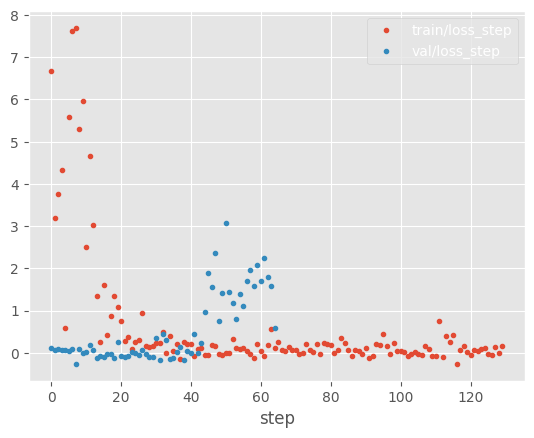

In [17]:
from src.helpers.lightning import read_metrics_csv

_, df_hist = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
df_hist[['train/loss_step', 'val/loss_step']].plot(style='.')
df_hist


## Generate


In [18]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16, # bfloat can't be pickled
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
# get a row
bi = 2
inputs = ds_tokens.with_format("torch")[bi]

from src.eval.gen import gen


In [20]:
with model.disable_adapter():
    gen(model, inputs, tokenizer)

gen(model, inputs, tokenizer)


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


# Test

In [21]:
from src.eval.helpers import test_intervention_quality2
from src.eval.labels import ds2label_model_obey, ds2label_model_truth


In [22]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size * 2)
dl_train2 = dm.train_dataloader()
dl_val2 = dm.val_dataloader()
dl_test2 = dm.test_dataloader()


In [23]:
dl_oos2 = DataLoader(
    ds_tokens2, batch_size=cfg.batch_size * 2, drop_last=False, shuffle=False
)
len(ds_tokens2)


130

In [24]:
# rs = trainer1.test(
#     net,
#     dataloaders=[
#         # dl_train2, dl_val2,
#         dl_test2,
#         dl_oos2,
#     ],
# )
# rs = rename(rs, ["train", "val", "test", "oos"])
# rs[0]


# Predict

Here we want to see if we can do a probe on the hidden states to see if it's lying...


### Collect

- see how acc each was for instructions vs truth
- see how a linear probe trained on the diff can do for truth, vs baseline

In [27]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16, # bfloat can't be pickled
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [45]:
from src.eval.collect import manual_collect2
ds_out, f = manual_collect2(dl_oos2, model, dataset_name="oos")


2023-12-21 20:26:39.444 | INFO     | src.eval.collect:manual_collect2:55 - creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_oos_0b79abd79d3d5e47
2023-12-21T20:26:39.444557+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_oos_0b79abd79d3d5e47
collecting hidden states:  36%|███▋      | 8/22 [00:35<01:02,  4.48s/it]

### Eval

In [ ]:
for label_name, label_fn in dict(label_model_truth=ds2label_model_truth, label_model_obey=ds2label_model_obey).items():
    # fit probe
    print('='*80)
    print('making intervention with', label_name, 'hidden states')
    test_intervention_quality2(ds_out, label_fn, tokenizer)


making intervention with label_model_truth hidden states
primary metric: predictive power (of logistic regression on top of intervened hidden states)
predictive power? False [i] = baseline: 0.499 > 0.464 roc_auc
predictive power? True [i-b] = baseline: 0.499 > 0.562 roc_auc
predictive power? False [diff]  = baseline: 0.512 > 0.478 roc_auc
predictive power? True [diff(i-b)] = baseline: 0.512 > 0.543 roc_auc
           baseline  intervene
coverage  58.823467  88.774399
ans        0.489107   0.498124
making intervention with label_model_obey hidden states
primary metric: predictive power (of logistic regression on top of intervened hidden states)
predictive power? False [i] = baseline: 0.404 > 0.398 roc_auc
predictive power? False [i-b] = baseline: 0.404 > 0.417 roc_auc
predictive power? False [diff]  = baseline: 0.404 > 0.398 roc_auc
predictive power? False [diff(i-b)] = baseline: 0.404 > 0.417 roc_auc
           baseline  intervene
coverage  58.823467  88.774399
ans        0.489107   0.

### Check dataset of outputs

In [ ]:
from src.eval.ds import qc_ds


In [ ]:
qc_ds(ds_out)


	acc    =	55.38% [N=65] - when the model is not lying... we get this task acc
	lie_acc=	55.38% [N=65] - when the model tries to lie... we get this acc


Using sep_token, but it is not set yet.


KeyError: "None of ['example_i'] are in the columns"